[Inspiration](https://cran.r-project.org/web/packages/tsfknn/vignettes/tsfknn.html)

In [ ]:
import pandas as pd
from google.colab import files 
uploaded = files.upload()

Saving aapl.us.txt to aapl.us.txt


In [ ]:
df = pd.read_csv('aapl.us.txt')
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [ ]:
#data preprocessing

#We parse the date to the correct format
df['Date'] = pd.to_datetime(df['Date'])
#df.info()

#UNcomment if you want to exclude those before 2000.
#df = df[df['Date'].dt.year >= 2000]


#creating another date column for month, year and quarter so we can 'groupby' later
df['month'] = df['Date'].dt.to_period("M")
df['year'] = df['Date'].dt.to_period("Y")
df['quarter'] = df['Date'].dt.quarter

#df for Monthly
df_month = df.groupby(['month']).agg(
    mean_open = pd.NamedAgg(column='Open', aggfunc='mean'),
    mean_high = pd.NamedAgg(column='High', aggfunc='mean'),
    mean_low = pd.NamedAgg(column='Low', aggfunc='mean'),
    mean_close = pd.NamedAgg(column='Close', aggfunc='mean'),
    mean_volume = pd.NamedAgg(column='Volume', aggfunc='mean')
)

#df for Quarterly 
df_quarter = df.groupby(['year', 'quarter']).agg(
    mean_open = pd.NamedAgg(column='Open', aggfunc='mean'),
    mean_high = pd.NamedAgg(column='High', aggfunc='mean'),
    mean_low = pd.NamedAgg(column='Low', aggfunc='mean'),
    mean_close = pd.NamedAgg(column='Close', aggfunc='mean'),
    mean_volume = pd.NamedAgg(column='Volume', aggfunc='mean')
)

In [ ]:
df_day = df.drop(['Date', 'Open', 'High', 'Low', 'Volume', 'OpenInt', 'month', 'year', 'quarter'], axis=True)
df_month.reset_index(inplace=True)
df_month = df_month.drop(['month', 'mean_open', 'mean_high', 'mean_low', 'mean_volume'], axis=True)
df_quarter.reset_index(inplace=True)
df_quarter = df_quarter.drop(['year', 'quarter', 'mean_open', 'mean_high', 'mean_low', 'mean_volume'], axis=True)


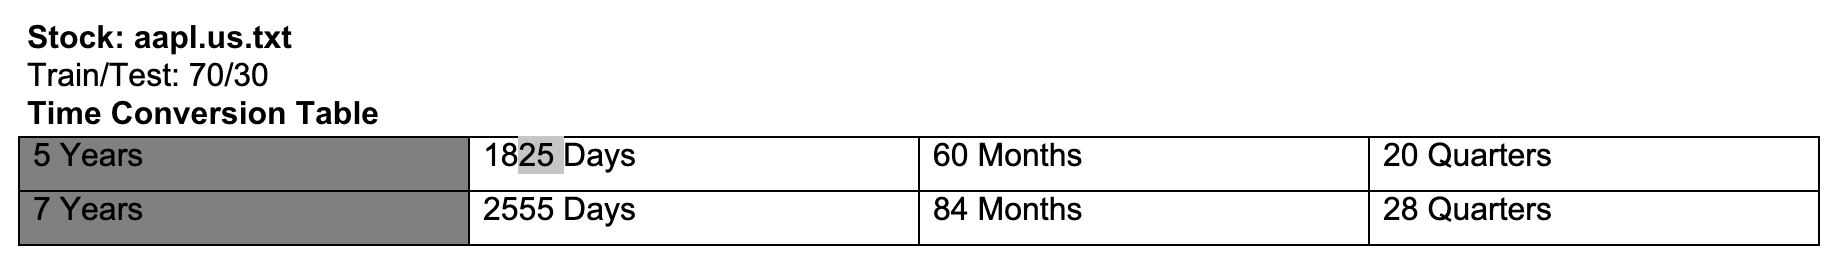

In [ ]:
#(data points, attribute)
instructions = {'5year.day': (1825, 'Close', 0),
                '5year.month': (60, 'mean_close', 1),
                '5year.quarter': (20, 'mean_close', 2),
                '7year.day': (2555, 'Close', 0),
                '7year.month': (84, 'mean_close', 1),
                '7year.quarter': (28, 'mean_close', 2),
                '30point.day': (30, 'Close', 0),
                '30point.month': (30, 'mean_close', 1),
                '30point.quarter': (30, 'mean_close', 2) ,
                '35point.day': (35, 'Close', 0),
                '35point.month': (35, 'mean_close', 1),
                '35point.quarter': (35, 'mean_close', 2),
                }

#command
df_type = [df_day, df_month, df_quarter]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1152x576 with 0 Axes>

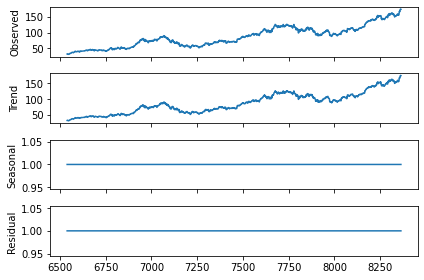

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 8))
result = seasonal_decompose(df_day['Close'][-1825:], freq=1, model='multiplicative')
result.plot()
plt.show()

The Autocorrelation plot for the data is:


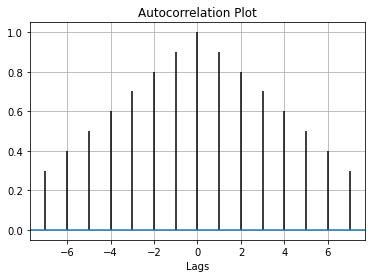

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = df_day['Close'][-10:]
   
# Adding plot title.
plt.title("Autocorrelation Plot")
 
# Providing x-axis name.
plt.xlabel("Lags")
 
# Plotting the Autocorrelation plot.
plt.acorr(data, maxlags = 7)
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show()

In [ ]:
def sliding_window(instructions):
  from math import sqrt, ceil
  from sklearn.metrics import mean_squared_error
  for i, (name, v) in enumerate(instructions.items()):
    pts, att, command = v
    #Change sampling
    data = df_type[command][-pts:]
    attribute = att

    #Train test split
    train = data[:int(len(data)*0.7)]
    test = data[int(len(data)*0.7):]

    window_size = int(len(train)/5)
    recommended_k = []
    for i in range(0, len(train)-window_size, max(1,int(window_size/3))):
      window = train[:i+window_size]
      train_window = window[:int(len(window)*0.7)]
      test_window = window[int(len(window)*0.3):]
      temp = []
      for k in range(2, 4):
        previous_points = train_window[-k:][attribute]
        sum = 0
        for p in previous_points:
          if (type(p)==str):
            continue
          sum += p;
        average = sum/len(previous_points)

        prediction = [average,]*len(test_window)
        prediction = pd.DataFrame(prediction)
        prediction.index = test_window.index

        #RMSE Calculation
        RMSE = sqrt(mean_squared_error(test_window, prediction))
        temp.append((k, RMSE),)
      
      temp.sort(key=lambda x: x[0]) #sort by k
      temp.sort(key=lambda x: x[1]) #sort by rmse (STABLE SORT)
      recommended_k.append(temp[0][0])
  total = 0
  for i in recommended_k:
    total += i

  print(recommended_k)
  result = ceil(total/len(recommended_k))
  return result

print('Use k = ' +str(sliding_window(instructions)));


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2]
Use k = 3


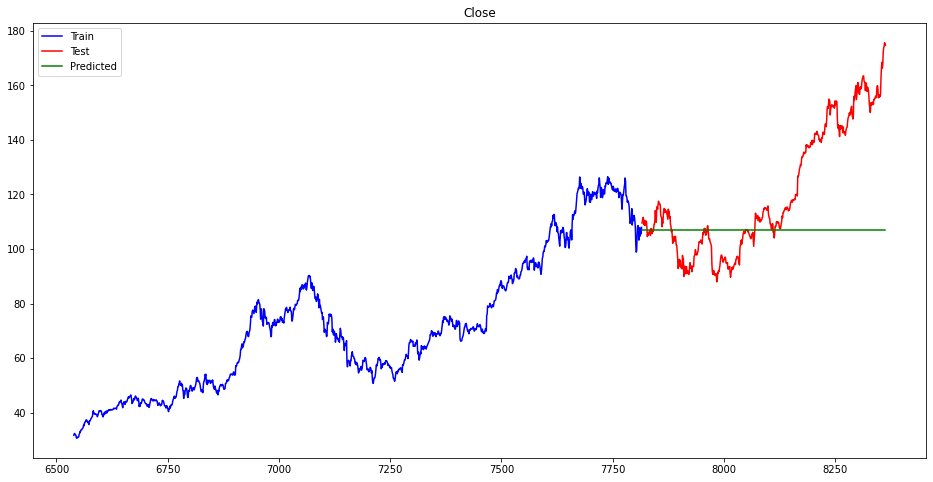

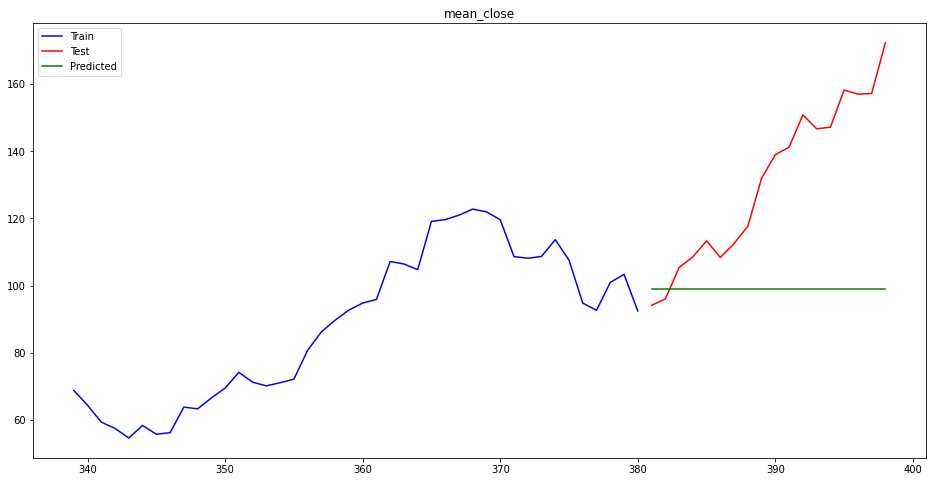

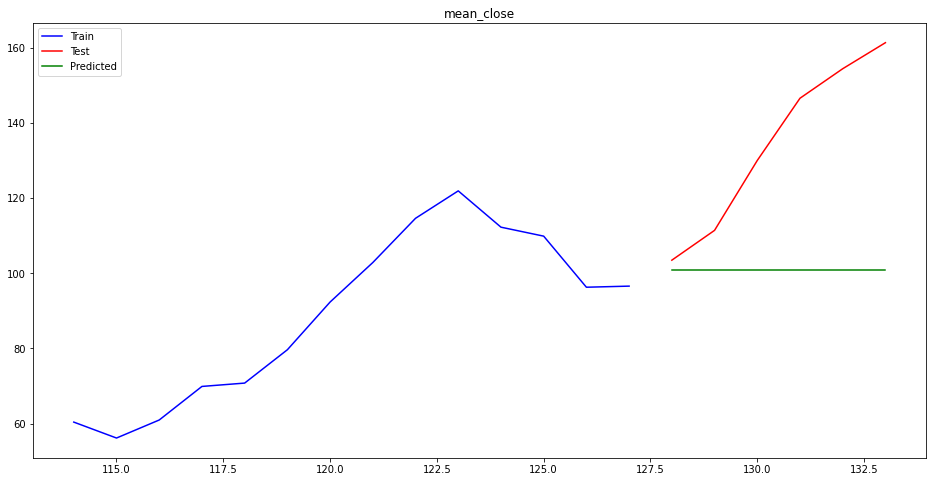

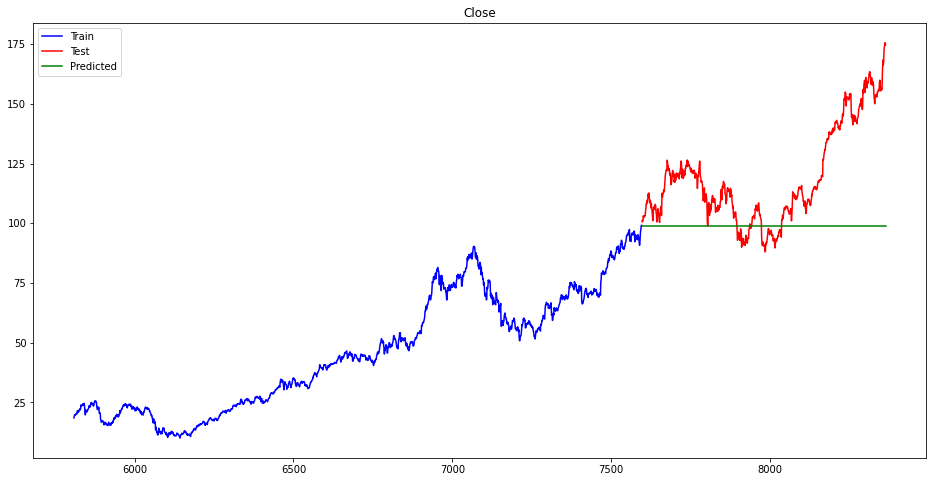

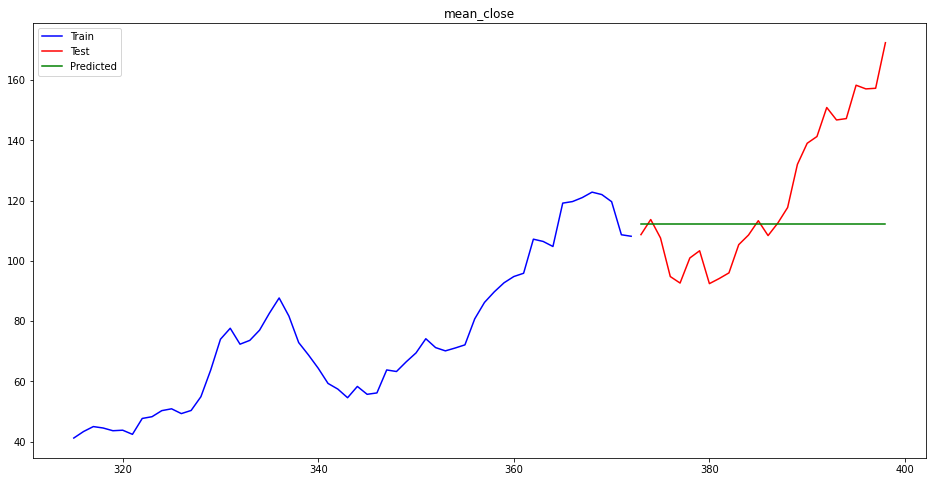

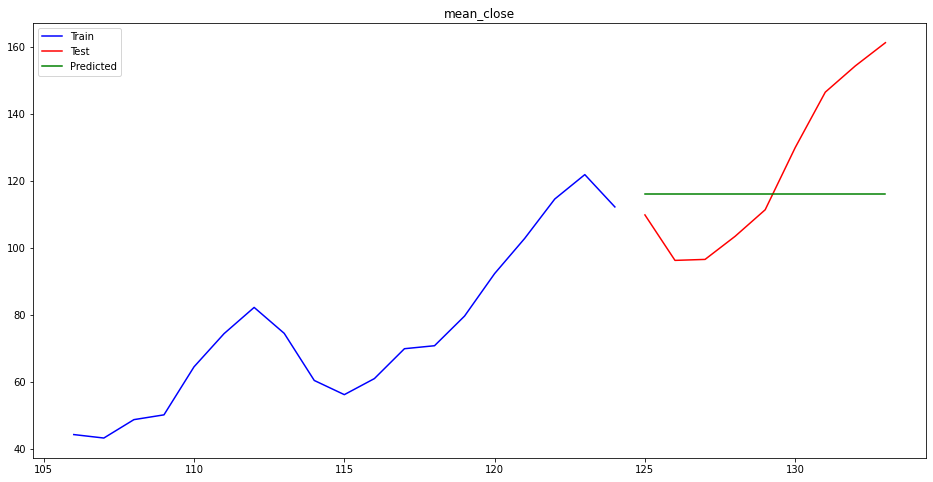

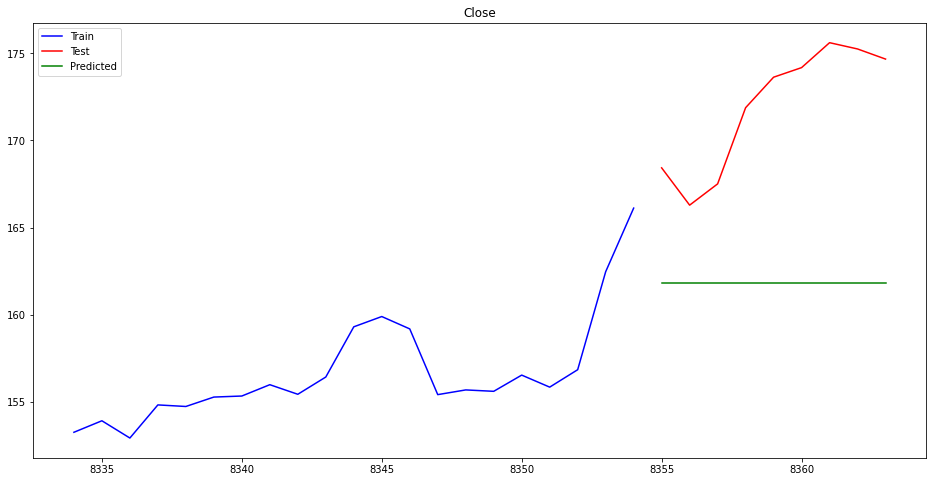

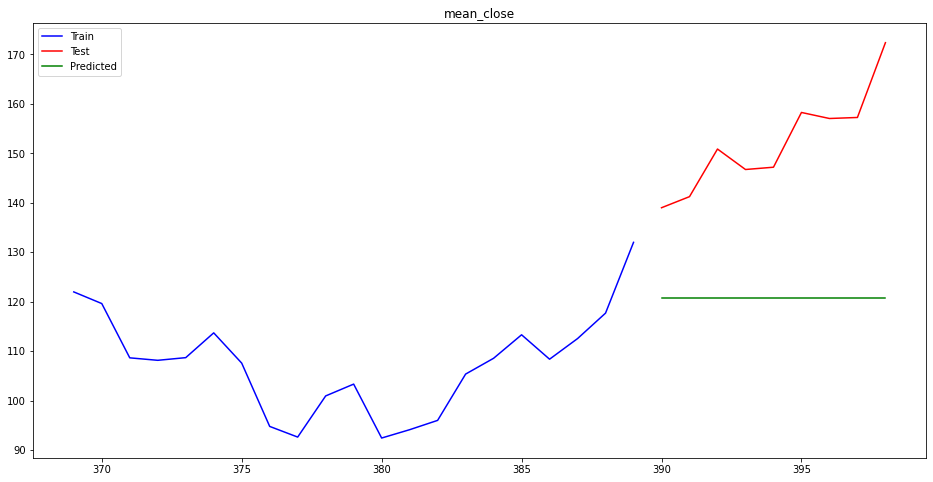

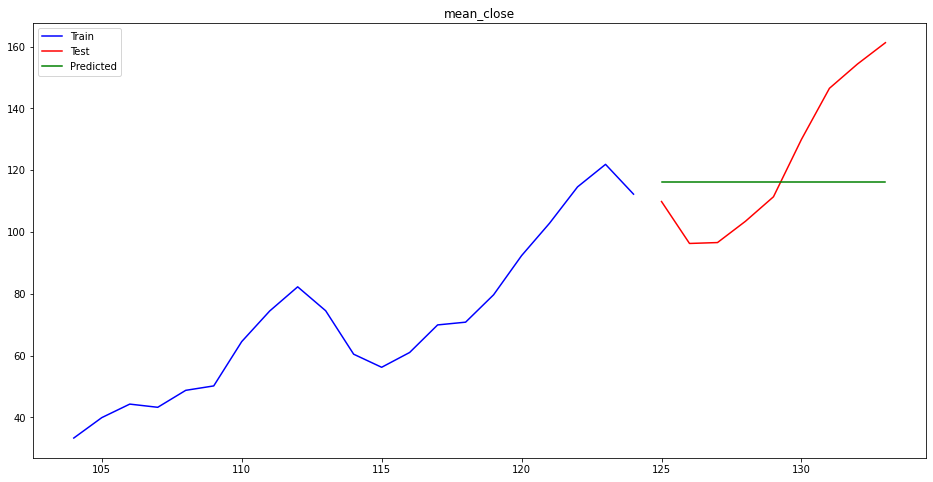

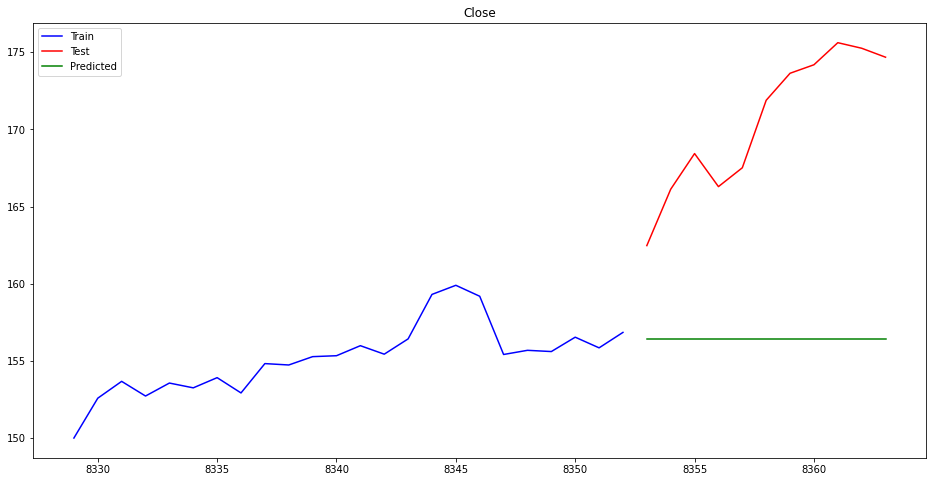

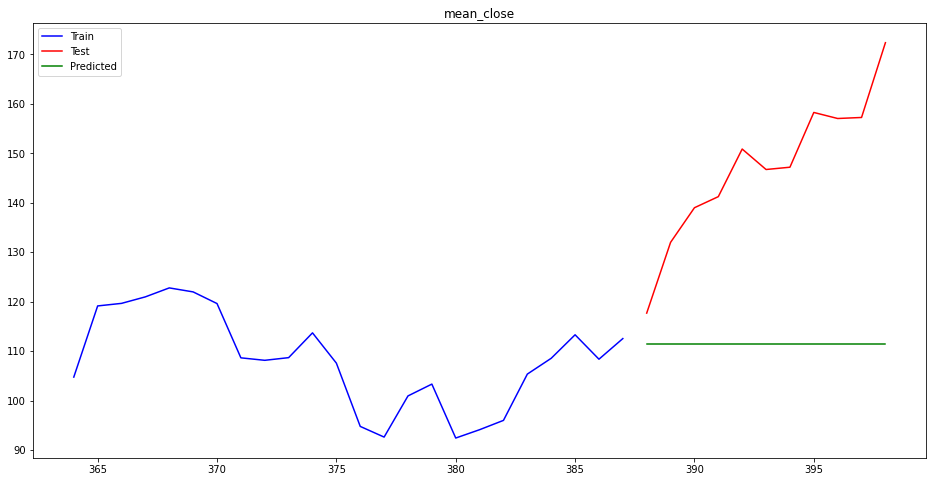

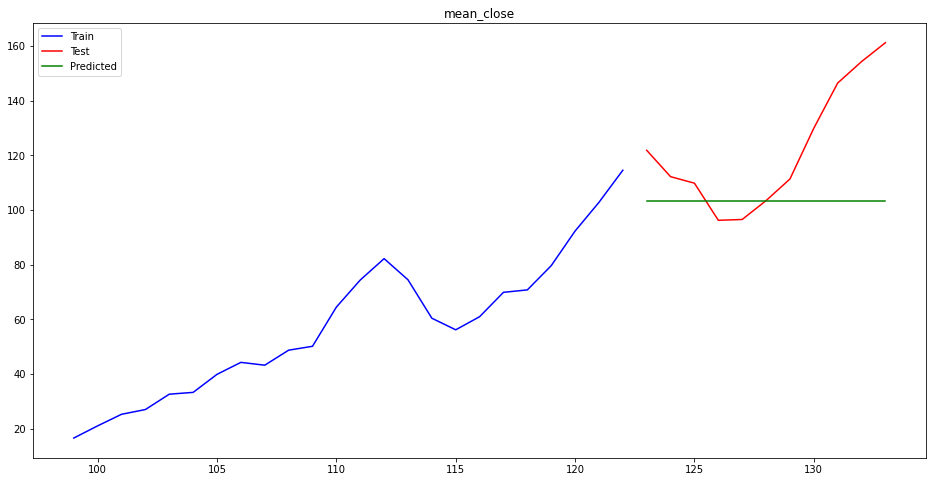

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

Result_RMSE = {}

for name, v in instructions.items():
  pts, att, command = v
  #Change sampling
  data = df_type[command][-pts:]
  attribute = att

  #Train test split
  train = data[:int(len(data)*0.7)]
  test = data[int(len(data)*0.7):]

  # k-Nearest point
  k = 3
  previous_points = train[-k:][attribute]
  sum = 0
  for p in previous_points:
    if (type(p)==str):
      continue
    sum += p;
  average = sum/len(previous_points)

  prediction = [average,]*len(test)
  prediction = pd.DataFrame(prediction)
  prediction.index = test.index

  #RMSE Calculation
  RMSE = sqrt(mean_squared_error(test, prediction))
  Result_RMSE[name] = RMSE;

  #Plot Graph
  plt.figure(figsize=(16, 8))
  plt.plot(train, color = 'blue', label = "Train")
  plt.plot(test, color = 'red', label = "Test")
  plt.plot(prediction, color = 'green', label = "Predicted")
  plt.title(attribute)
  plt.legend()
  
  #plt.savefig(name+'.png')
  #files.download(name+'.png')

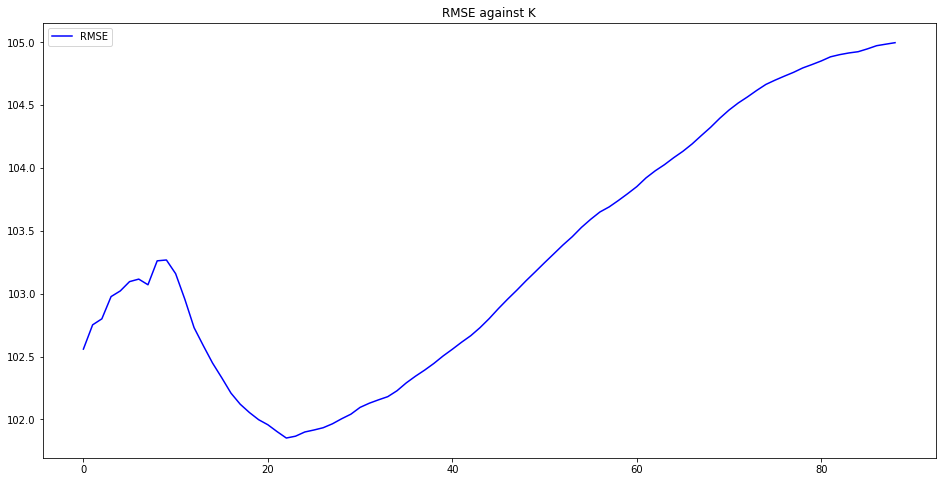

In [ ]:
possible = []

# For Example,
data = df_day
attribute = 'Close'
train = data[:int(len(data)*0.7)]

# k-Nearest point
for k in range(1,90):
  previous_points = train[-k:][attribute]
  sum = 0
  for p in previous_points:
    if (type(p)==str):
      continue
    sum += p;
  average = sum/len(previous_points)

  prediction = [average,]*len(test)
  prediction = pd.DataFrame(prediction)
  prediction.index = test.index

  #RMSE Calculation
  RMSE = sqrt(mean_squared_error(test, prediction))
  possible.append(RMSE)

plt.figure(figsize=(16, 8))
plt.plot([i for i in range(len(possible))],possible, color = 'blue', label = "RMSE")
plt.title("RMSE against K")
plt.legend()

In [ ]:
for name, v in Result_RMSE.items():
  print(name, v)

5year.day 26.837533259092336
5year.month 39.818733537017344
5year.quarter 39.88786255929795
7year.day 28.350025216658373
7year.month 26.095054468304404
7year.quarter 24.94340627856607
30point.day 10.6789750167049
30point.month 32.94031975419726
30point.quarter 24.94340627856607
35point.day 14.783009767221895
35point.month 38.50219875866916
35point.quarter 28.909827612418812
